# 내일은 얼마조 ?
원유, 환율, 다우지수, S&P500을 이용한 국내 항공업 주가 예측하기

#1.필요한 데이터 가져오기 : finance-datareader 

- investing.com에서 주식 정보를 가져오는 파이썬 오픈 소스 라이브러리

- 유의사항 : 이런 오픈 소스 라이브러리들은 해외 주식 사이트에서 API 등 사용해 데이터를 가져옵니다. 해당 사이트의 API 지원이 중단되거나, 라이브러리 자체에 변경사항이 있으면, 데이터를 가져오는 기능이 잠시 원활하지 않을 수도 있습니다. 그래서 테스트 용도로 주식 가격을 활용하고자 할 때 추천드립니다.



In [1]:
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import FinanceDataReader as fdr

### 원유

원유 가격의 경우, 
* Finance Data Reader의 데이터가 *investing.com*의 데이터와 불일치
* **-->** *investing.com*의 데이터를 직접 다운받아 불러오는 방식으로 처리

원유 가중치 계산:

0.8 * dubai + 0.15 * brent + 0.05 * wti

(참고 논문에 따라, 수입 의존도에 따른 가중을 두어 기준유가를 계산해 사용함)



In [3]:
from google.colab import files
myFile = files.upload()

Saving 두바이유 내역.csv to 두바이유 내역.csv
Saving 브렌트유 선물 내역.csv to 브렌트유 선물 내역.csv
Saving WTI유 선물 내역.csv to WTI유 선물 내역.csv


In [4]:
import pandas as pd
wti = pd.read_csv('WTI유 선물 내역.csv')
wti

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022- 11- 01,87.98,86.17,88.24,85.92,NaN,1.68%
1,2022- 10- 31,86.53,88.39,88.65,85.30,285.34K,-2.09%
2,2022- 10- 30,88.38,88.54,88.63,88.20,NaN,0.55%
3,2022- 10- 28,87.90,88.67,88.76,87.08,263.40K,-1.32%
4,2022- 10- 27,89.08,88.26,89.79,87.33,292.56K,1.33%
...,...,...,...,...,...,...,...
1055,2018- 11- 02,57.02,56.60,56.65,56.50,0.49K,0.44%
1056,2018- 11- 01,56.77,58.02,58.20,56.50,0.26K,-2.44%
1057,2018- 10- 31,58.19,58.51,58.72,58.00,0.14K,-0.65%
1058,2018- 10- 30,58.57,59.49,59.49,58.50,0.13K,-1.76%


In [5]:
dubai = pd.read_csv('두바이유 내역.csv')
dubai

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022- 10- 31,91.13,91.13,91.13,91.13,NaN,0.02%
1,2022- 10- 28,91.11,91.11,91.11,91.11,NaN,-0.17%
2,2022- 10- 27,91.26,91.27,91.27,91.27,NaN,0.11%
3,2022- 10- 26,91.16,91.16,91.16,91.16,NaN,0.35%
4,2022- 10- 25,90.84,90.84,90.84,90.84,NaN,-0.04%
...,...,...,...,...,...,...,...
963,2019- 01- 03,54.76,54.76,54.76,54.76,NaN,1.61%
964,2019- 01- 02,53.89,53.89,53.89,53.89,NaN,-5.98%
965,2018- 12- 31,57.32,57.32,57.32,57.32,NaN,0.00%
966,2018- 12- 28,57.32,57.32,57.32,57.32,NaN,0.07%


In [6]:
brent = pd.read_csv('브렌트유 선물 내역.csv')
brent

,날짜,종가,오픈,고가,저가,거래량,변동 %
0,2022- 11- 01,94.48,92.47,94.74,92.33,NaN,-0.37%
1,2022- 10- 31,94.83,96.47,96.47,94.25,15.00K,1.13%
2,2022- 10- 28,93.77,94.61,94.90,93.02,281.47K,-1.34%
3,2022- 10- 27,95.04,94.15,95.30,93.18,247.96K,1.33%
4,2022- 10- 26,93.79,91.12,94.30,90.39,262.01K,2.23%
...,...,...,...,...,...,...,...
990,2019- 01- 03,55.95,54.29,56.30,53.93,278.36K,1.89%
991,2019- 01- 02,54.91,54.12,56.56,52.51,300.95K,2.06%
992,2018- 12- 31,53.80,53.00,54.82,52.66,109.11K,3.07%
993,2018- 12- 28,52.20,53.44,53.80,51.60,17.11K,0.08%


In [7]:
# 날짜 재정렬: 오래된 날짜부터 최신 날짜까지의 순서로 다시 정렬

oil_list = [wti, dubai, brent]
oil_list_names = ['WTI', 'Dubai', 'Brent']

for i in oil_list:
  i = i[::-1]
  i.reset_index(drop=True, inplace=True)
  print(i)

                날짜     종가     오픈     고가     저가      거래량    변동 %
0     2018- 10- 29  59.62  59.46  59.50  59.25    0.29K   0.57%
1     2018- 10- 30  58.57  59.49  59.49  58.50    0.13K  -1.76%
2     2018- 10- 31  58.19  58.51  58.72  58.00    0.14K  -0.65%
3     2018- 11- 01  56.77  58.02  58.20  56.50    0.26K  -2.44%
4     2018- 11- 02  57.02  56.60  56.65  56.50    0.49K   0.44%
...            ...    ...    ...    ...    ...      ...     ...
1055  2022- 10- 27  89.08  88.26  89.79  87.33  292.56K   1.33%
1056  2022- 10- 28  87.90  88.67  88.76  87.08  263.40K  -1.32%
1057  2022- 10- 30  88.38  88.54  88.63  88.20      NaN   0.55%
1058  2022- 10- 31  86.53  88.39  88.65  85.30  285.34K  -2.09%
1059  2022- 11- 01  87.98  86.17  88.24  85.92      NaN   1.68%

[1060 rows x 7 columns]
               날짜     종가     오픈     고가     저가  거래량    변동 %
0    2018- 12- 27  57.28  57.28  57.28  57.28  NaN  -0.24%
1    2018- 12- 28  57.32  57.32  57.32  57.32  NaN   0.07%
2    2018- 12- 31  57.32  57.3

In [8]:
# 불필요한 칼럼 삭제

for i in oil_list:
  i.drop(['오픈','고가','저가','거래량','변동 %'], axis=1, inplace=True)

In [9]:
# 날짜 데이터 타입 통일을 위해 datetime 타입으로 변경

for i in oil_list:
  i['날짜'] = pd.to_datetime(i['날짜'])

In [10]:
#변경된 것 확인
wti['날짜']

0      2022-11-01
1      2022-10-31
2      2022-10-30
3      2022-10-28
4      2022-10-27
          ...    
1055   2018-11-02
1056   2018-11-01
1057   2018-10-31
1058   2018-10-30
1059   2018-10-29
Name: 날짜, Length: 1060, dtype: datetime64[ns]

In [11]:
# 변수 데이터들 간 형식 통일을 위해
# Date를 인덱스로, Close를 열로 변경

for i in oil_list:
  i.columns = ['Date','Close']
  i.set_index('Date',inplace=True)

In [12]:
wti

,Close
Date,
2022-11-01,87.98
2022-10-31,86.53
2022-10-30,88.38
2022-10-28,87.90
2022-10-27,89.08
...,...
2018-11-02,57.02
2018-11-01,56.77
2018-10-31,58.19


In [13]:
for i in oil_list:
  i['Close'] = i['Close'].astype(float)

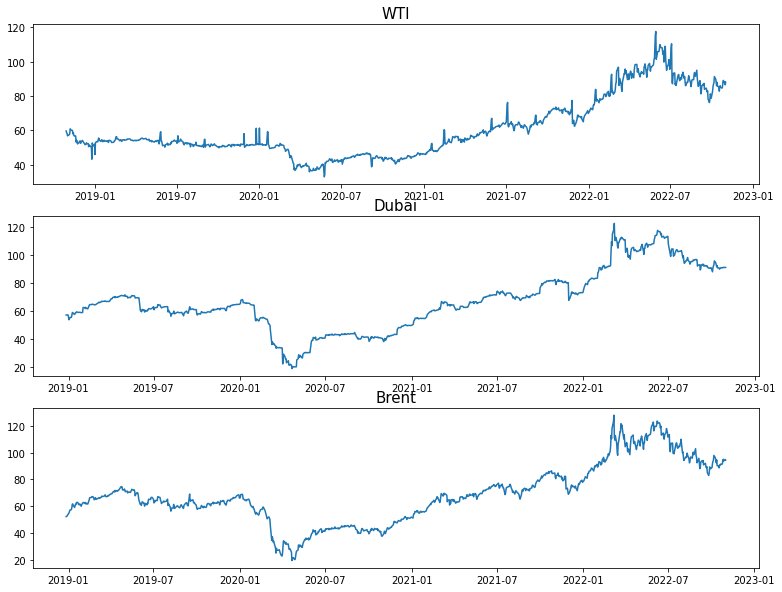

In [14]:
# 원유 3종 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(13,10))
for i,j in zip(range(1,4), oil_list):
  plt.subplot(3,1,i)
  plt.title("%s" % oil_list_names[i-1], size = 15)
  plt.plot(j)


In [15]:
# 가중치 계산식에 맞게 기준유가 변수 정의

oil_price = 0.8 * dubai + 0.15 * brent + 0.05 * wti

In [16]:
oil_price

,Close
Date,
2018-10-29,NaN
2018-10-30,NaN
2018-10-31,NaN
2018-11-01,NaN
2018-11-02,NaN
...,...
2022-10-27,91.7180
2022-10-28,91.3485
2022-10-30,NaN


In [17]:
oil_price.isnull().sum()

Close    93
dtype: int64

In [18]:
# 결측치 제거
oil_price.dropna(axis=0, inplace=True)

In [19]:
oil_price

,Close
Date,
2018-12-27,56.2005
2018-12-28,56.2280
2018-12-31,56.5195
2019-01-02,53.9825
2019-01-03,54.8530
...,...
2022-10-25,90.6990
2022-10-26,91.3920
2022-10-27,91.7180


Text(0, 0.5, 'Oil Price')

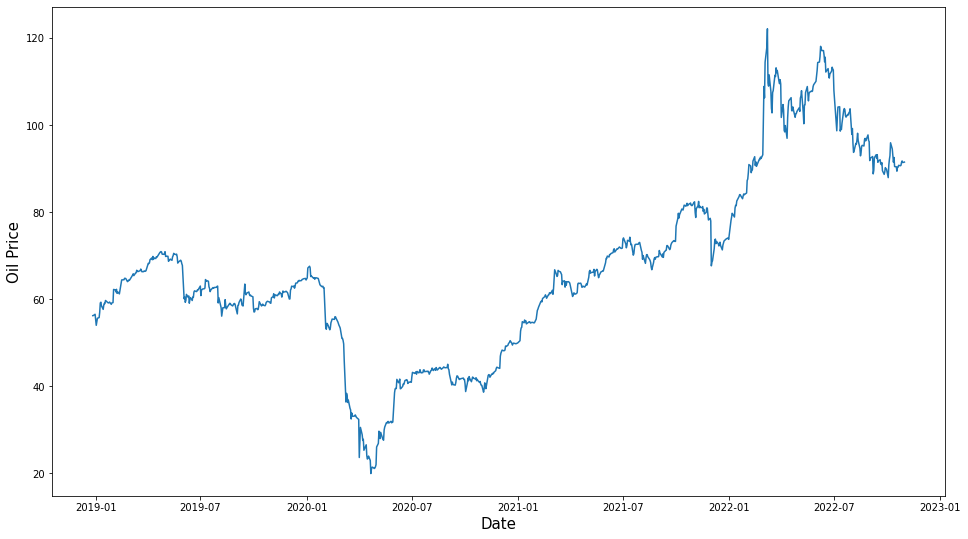

In [20]:
# 기준유가 시각화

plt.figure(figsize=(16,9))
plt.plot(oil_price)
plt.xlabel('Date', size = 15)
plt.ylabel('Oil Price', size = 15)

### S&P 500

In [21]:
df_SP500 = fdr.DataReader('US500', '2018-12-27')

In [22]:
df_SP500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4096610000
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3702620000
2018-12-31,2498.939941,2509.239990,2482.820068,2506.850098,2506.850098,3442870000
2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000
2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3822860000
...,...,...,...,...,...,...
2022-10-25,3799.439941,3862.850098,3799.439941,3859.110107,3859.110107,4843120000
2022-10-26,3825.969971,3886.149902,3824.070068,3830.600098,3830.600098,4817310000
2022-10-27,3834.689941,3859.949951,3803.790039,3807.300049,3807.300049,4687320000


In [23]:
df_SP500.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### USD/KRW 환율

In [24]:
df_USD = fdr.DataReader('USD/KRW', start = '2018-12-27')

In [25]:
df_USD

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-27,1122.530029,1123.599976,1118.099976,1123.520020,1123.520020,0.0
2018-12-28,1118.199951,1121.270020,1113.329956,1119.599976,1119.599976,0.0
2018-12-31,1116.349976,1116.349976,1108.500000,1116.300049,1116.300049,0.0
2019-01-01,1112.449951,1113.400024,1111.000000,1112.500000,1112.500000,0.0
2019-01-02,1113.829956,1122.420044,1113.000000,1113.800049,1113.800049,0.0
...,...,...,...,...,...,...
2022-10-26,1426.930054,1432.209961,1409.930054,1426.930054,1426.930054,0.0
2022-10-27,1412.689941,1424.510010,1412.030029,1412.689941,1412.689941,0.0
2022-10-28,1420.650024,1428.119995,1412.319946,1420.650024,1420.650024,0.0


In [26]:
df_USD.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [27]:
df_USD[ df_USD['Close'].isnull() ]    # 결측치 자리 찾기

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-22,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_USD = df_USD.drop('2019-05-22', 0)   #결측치 제외하기

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


### 다우존스

In [29]:
#다우존스 가격
df_DJI = fdr.DataReader('DJI', start  = '2018-12-27')

In [30]:
df_DJI

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-27,22629.060547,23138.890625,22267.419922,23138.820313,23138.820313,407940000
2018-12-28,23213.609375,23381.880859,22981.330078,23062.400391,23062.400391,336510000
2018-12-31,23153.939453,23333.179688,23118.300781,23327.460938,23327.460938,288830000
2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,23346.240234,321570000
2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,22686.220703,424240000
...,...,...,...,...,...,...
2022-10-25,31463.650391,31876.150391,31423.529297,31836.740234,31836.740234,336930000
2022-10-26,31738.439453,32172.419922,31738.439453,31839.109375,31839.109375,430400000
2022-10-27,32062.140625,32388.419922,31993.210938,32033.279297,32033.279297,375720000


In [31]:
df_DJI.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### **TARGET DATA** 항공업 주가 데이터
- 항공사 전반적 추세 확인 위해 전체 항공 여객 운송업 데이터 이용
- 문제점: 에어부산의 가장 최신 데이터가 2018년 12월 27일이라 그때부터의 데이터를 합함

**항공 여객 운송업 종목 모으기**

finance data reader 데이터가 변경되기 전 (2022.10.10 기준),

"항공 여객 운송업" 부문 코드 찾은 내용

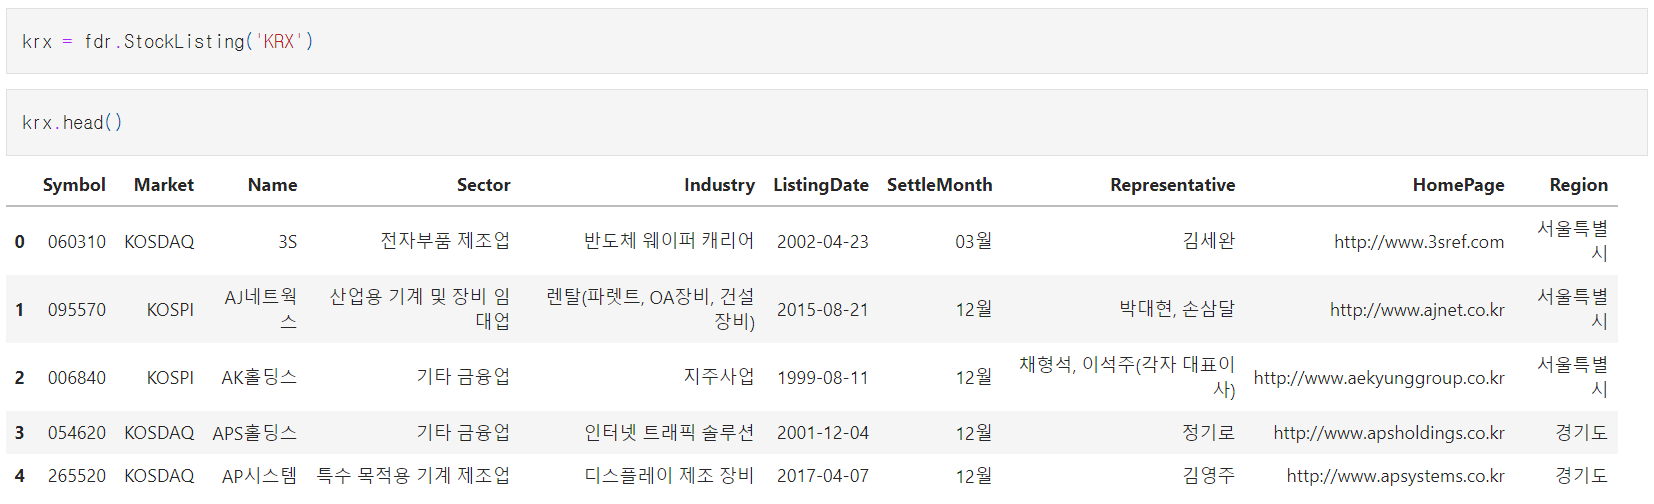

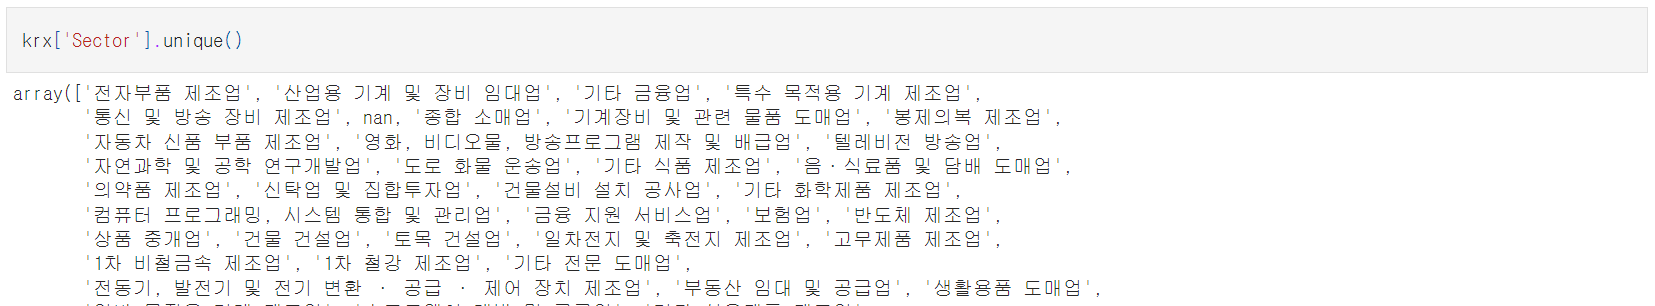

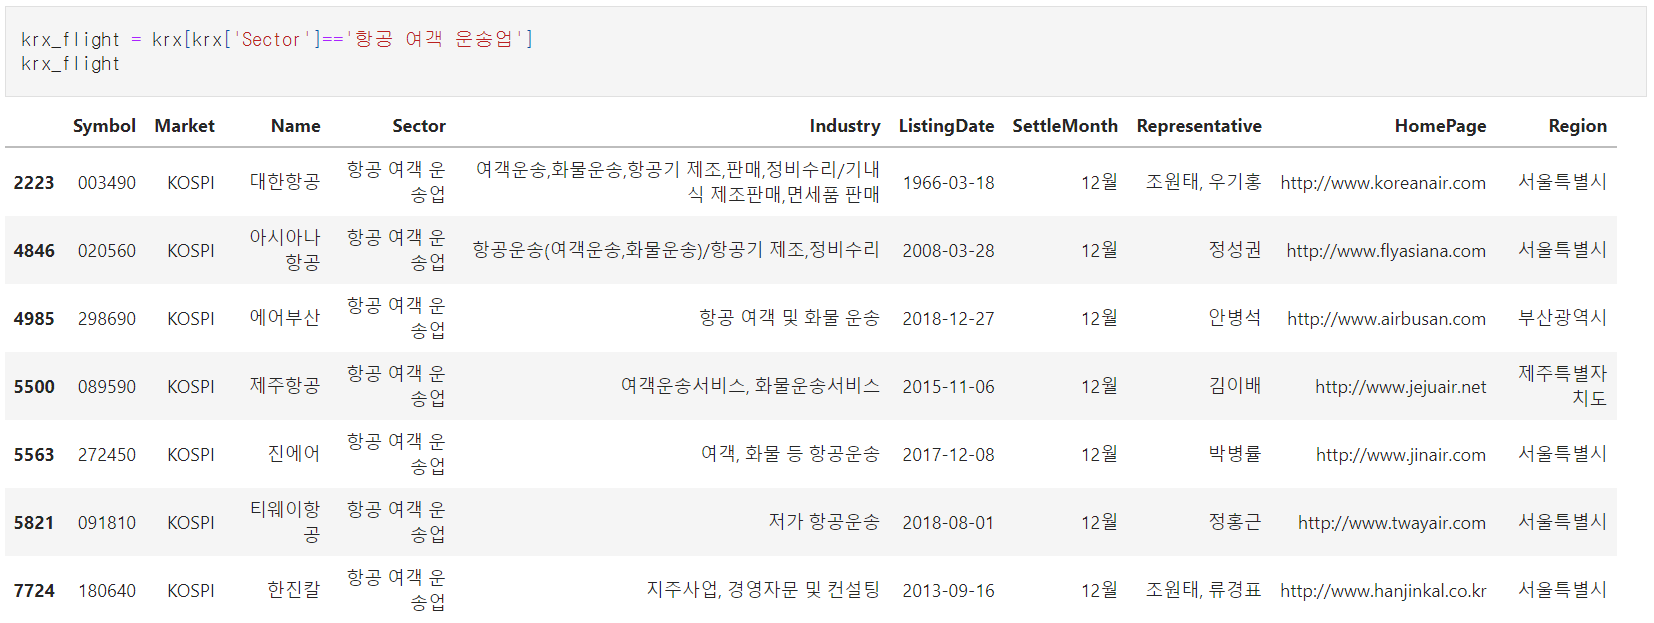

위에서 찾은 Symbol을 토대로 현재 변경된 (2022-10-31 기준) 데이터에서 항공 여객 운송업 부문 추출

In [32]:
# 위와 같은 데이터 사용
# !pip install -U finance-datareader

In [33]:
krx = fdr.StockListing('KRX')

In [34]:
krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,60000,1,600,1.01,59900,60300,59500,17201647,1030380927406,358186953000000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,563000,1,35000,6.63,534000,563000,533000,516467,284507717000,131742000000000,234000000,STK
2,207940,KR7207940008,삼성바이오로직스,KOSPI,,882000,1,5000,0.57,886000,887000,874000,50346,44298171000,62775468000000,71174000,STK
3,000660,KR7000660001,SK하이닉스,KOSPI,,83900,1,1200,1.45,82700,83900,81400,3820185,316973841612,61079398423500,728002365,STK
4,006400,KR7006400006,삼성SDI,KOSPI,,760000,1,23000,3.12,735000,760000,732000,407364,304321509000,52261042800000,68764530,STK


In [35]:
krair = fdr.DataReader('003490')
asair = fdr.DataReader('020560')
buair = fdr.DataReader('298690')
jejuair = fdr.DataReader('089590')
jinair = fdr.DataReader('272450')
twair = fdr.DataReader('091810')
hjkair = fdr.DataReader('180640')

In [36]:
asair.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')

In [37]:
list = [krair,asair,buair,jejuair,jinair,twair,hjkair]
for i in list:
    i.drop(['Open', 'High', 'Low', 'Volume', 'Change'],axis=1,inplace=True)

In [38]:
# 항공사 모은 변수 aviation 정의
aviation = krair + asair + buair + jejuair + jinair + twair + hjkair

In [39]:
# 에어부산 데이터 이전인 2018-12-26까지만 결측치, 이후에는 결측치 없는 것 확인

aviation[ aviation['Close'].isnull() ].tail(10)

,Close
Date,
2018-12-12,NaN
2018-12-13,NaN
2018-12-14,NaN
2018-12-17,NaN
2018-12-18,NaN
2018-12-19,NaN
2018-12-20,NaN
2018-12-21,NaN
2018-12-24,NaN


In [40]:
# 따라서 전체 항공사 주가 중 2018-12-27 자료만 사용
aviation = aviation['2018-12-27':]

In [41]:
aviation

,Close
Date,
2018-12-27,130327.0
2018-12-28,129391.0
2019-01-02,128195.0
2019-01-03,125100.0
2019-01-04,125096.0
...,...
2022-10-26,98235.0
2022-10-27,101140.0
2022-10-28,101735.0


In [42]:
aviation.isnull().sum() # 마지막으로 결측치 없는 것 확인

Close    0
dtype: int64

# 2.데이터셋 필요한 형태로 만들기 (df_close)
: **날짜(Date), 변수 별 종가(close)** 데이터

Date / SP500 close / WTI close / USD close / DJI close

In [43]:
import pandas as pd

In [44]:
dfs = [aviation, oil_price, df_SP500, df_USD, df_DJI]

In [45]:
names = ['AVIATION', 'OIL PRICE', 'SP500', 'USD', 'DJI']

In [46]:
df_close = pd.DataFrame()
for i in range(len(dfs)):
  test = pd.DataFrame()
  if i == 0:
    df_close[names[i]] = dfs[i]['Close']
  else:
    test[names[i]] = dfs[i]['Close']
    df_close = pd.merge(df_close, test, left_index = True, right_index  = True, how = 'outer')

In [47]:
# 결측치 있는 행 모아보기
df_close[df_close['AVIATION'].isnull() | df_close['OIL PRICE'].isnull() | df_close['SP500'].isnull() | df_close['USD'].isnull() | df_close['DJI'].isnull()]

,AVIATION,OIL PRICE,SP500,USD,DJI
Date,,,,,
2018-12-31,NaN,56.5195,2506.850098,1116.300049,23327.460938
2019-01-01,NaN,NaN,NaN,1112.500000,NaN
2019-01-21,127907.0,NaN,NaN,1125.790039,NaN
2019-02-04,NaN,62.1180,2724.870117,1118.300049,25239.369141
2019-02-05,NaN,61.6480,2737.699951,1121.099976,25411.519531
...,...,...,...,...,...
2022-09-09,NaN,92.4375,4067.360107,1383.000000,32151.710938
2022-09-12,NaN,93.1310,4110.410156,1379.060059,32381.339844
2022-10-03,NaN,87.8880,3678.429932,1439.229980,29490.890625


In [48]:
# 결측치 제거
df_close.dropna(axis = 0, inplace = True)

In [49]:
df_close

,AVIATION,OIL PRICE,SP500,USD,DJI
Date,,,,,
2018-12-27,130327.0,56.2005,2488.830078,1123.520020,23138.820313
2018-12-28,129391.0,56.2280,2485.739990,1119.599976,23062.400391
2019-01-02,128195.0,53.9825,2510.030029,1113.800049,23346.240234
2019-01-03,125100.0,54.8530,2447.889893,1122.180054,22686.220703
2019-01-04,125096.0,55.6030,2531.939941,1124.119995,23433.160156
...,...,...,...,...,...
2022-10-25,96435.0,90.6990,3859.110107,1443.959961,31836.740234
2022-10-26,98235.0,91.3920,3830.600098,1426.930054,31839.109375
2022-10-27,101140.0,91.7180,3807.300049,1412.689941,32033.279297


In [50]:
df_close.isnull().sum()

AVIATION     0
OIL PRICE    0
SP500        0
USD          0
DJI          0
dtype: int64

# 3.데이터 시각화해서 확인

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

Text(0, 0.5, 'price')

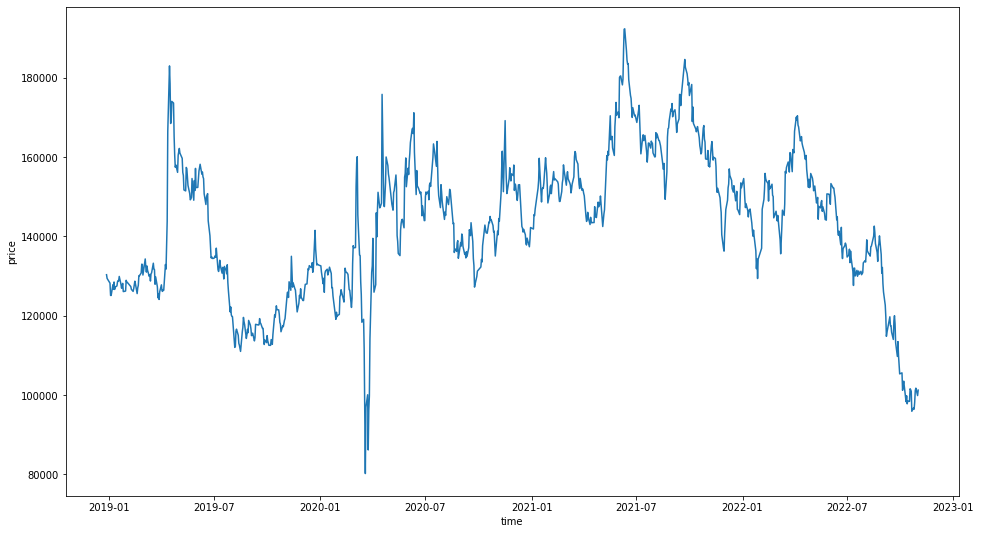

In [52]:
# 타겟변수 항공사 주가: aviation
plt.figure(figsize=(16,9))
plt.plot(aviation)
plt.xlabel('time')
plt.ylabel('price')

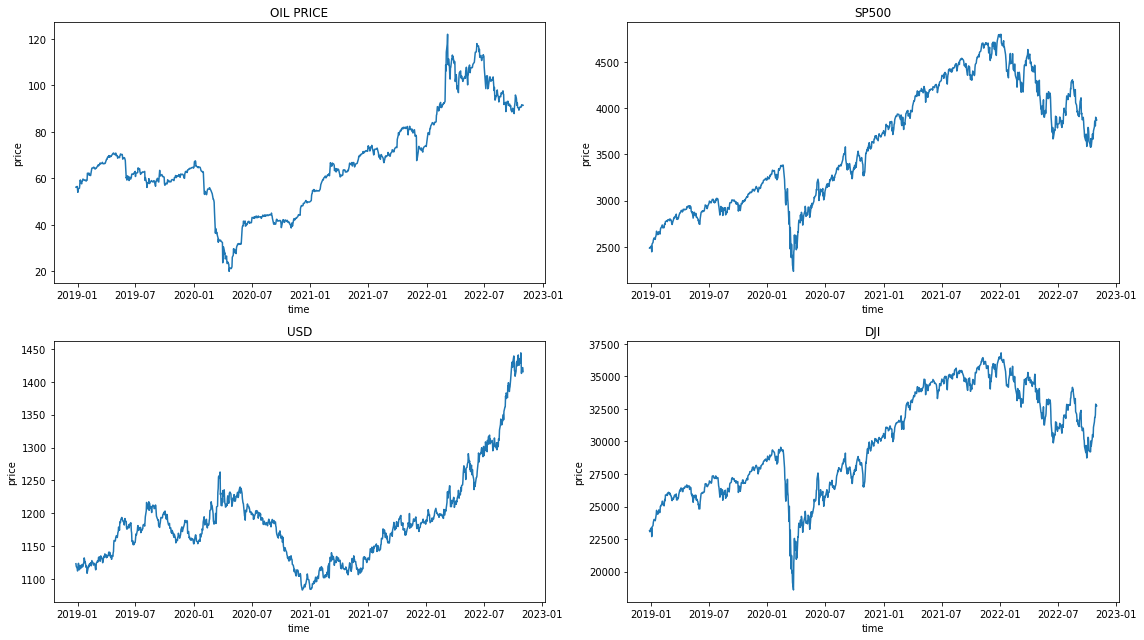

In [53]:
# 네 개의 데이터 한 번에 그려보기

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)


## 데이터셋 필요한 형태로 만들기에서 정의한 dfs, names 리스트 사용
for i in range( 4 ):
    ax = axes[i//2, i%2]
    sns.lineplot(y = dfs[i+1]['Close'], x = dfs[i+1].index, ax = ax)
    ax.set_title('%s' % names[i+1])
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [54]:
# 변수간 상관관계 확인
## table
df_close.corr()

,AVIATION,OIL PRICE,SP500,USD,DJI
AVIATION,1.000000,0.059238,0.516594,-0.405089,0.500440
OIL PRICE,0.059238,1.000000,0.591773,0.472822,0.626029
SP500,0.516594,0.591773,1.000000,0.089873,0.981880
USD,-0.405089,0.472822,0.089873,1.000000,0.028978
DJI,0.500440,0.626029,0.981880,0.028978,1.000000


<Figure size 1080x1080 with 0 Axes>

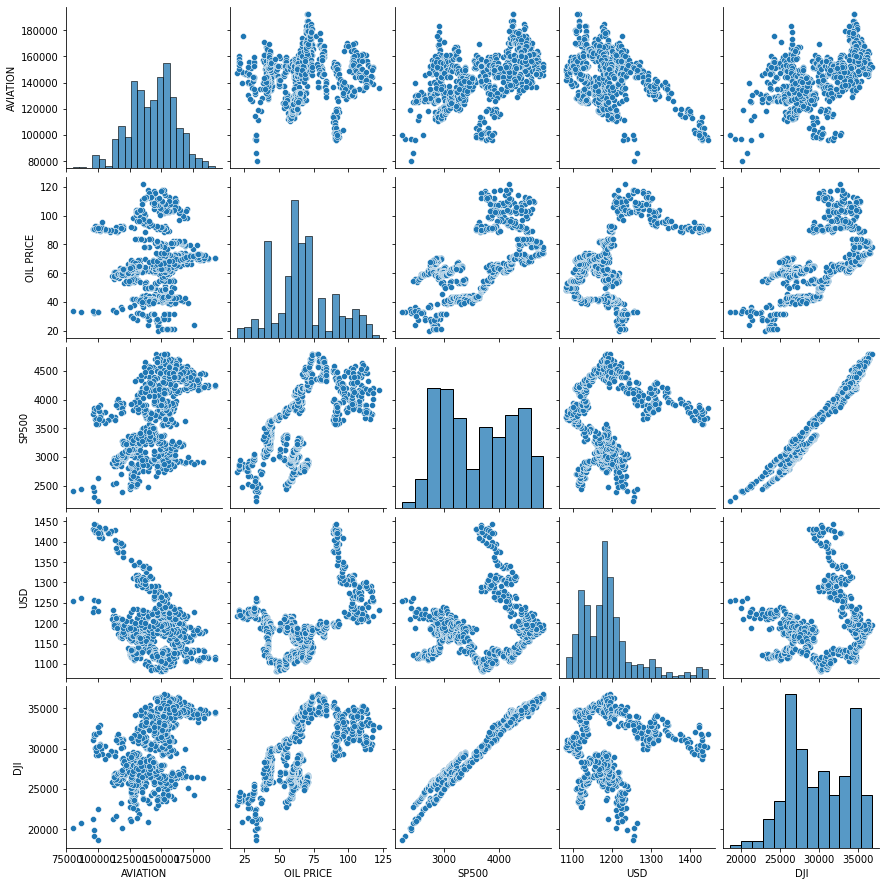

In [55]:
## 시각화
plt.figure(figsize=(15,15))
sns.pairplot(df_close)

선형 상관관계 찾을 수 없음

-> 선형 회귀분석 불가

-> LSTM 사용

# 4.데이터 전처리 (s_df_close)

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [56]:
from sklearn.preprocessing import MinMaxScaler

In [57]:
df_close.head()

,AVIATION,OIL PRICE,SP500,USD,DJI
Date,,,,,
2018-12-27,130327.0,56.2005,2488.830078,1123.520020,23138.820313
2018-12-28,129391.0,56.2280,2485.739990,1119.599976,23062.400391
2019-01-02,128195.0,53.9825,2510.030029,1113.800049,23346.240234
2019-01-03,125100.0,54.8530,2447.889893,1122.180054,22686.220703
2019-01-04,125096.0,55.6030,2531.939941,1124.119995,23433.160156


In [58]:
scaler = MinMaxScaler()

# 데이터셋 필요한 형태로 만들기에서 정의한 리스트 names 사용
scale_cols = names
scaled = scaler.fit_transform(df_close[scale_cols])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 유지했습니다.

*916개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [59]:
# Scaled DataFrame - 'CLOSE' column only
s_df_close = pd.DataFrame(scaled, columns = names, 
                          index = df_close.index)   # 인덱스 여기서 추가

In [60]:
s_df_close

,AVIATION,OIL PRICE,SP500,USD,DJI
Date,,,,,
2018-12-27,0.447126,0.355044,0.098247,0.110581,0.249723
2018-12-28,0.438775,0.355314,0.097040,0.099700,0.245526
2019-01-02,0.428104,0.333324,0.106531,0.083602,0.261115
2019-01-03,0.400489,0.341848,0.082250,0.106861,0.224866
2019-01-04,0.400453,0.349193,0.115092,0.112246,0.265889
...,...,...,...,...,...
2022-10-25,0.144730,0.692887,0.633688,1.000000,0.727428
2022-10-26,0.160790,0.699674,0.622548,0.952731,0.727558
2022-10-27,0.186709,0.702866,0.613443,0.913206,0.738223


# 5.데이터셋 train / test 분할

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

x_train, x_test, y_train, y_test = train_test_split(s_df_close.drop('AVIATION', 1), # '여타 특성값들(독립변수들)'
                                                    s_df_close['AVIATION'],   # '예측하고 싶은 타겟(종속변수)'
                                                    test_size=0.2, 
                                                    random_state=0, shuffle=False)

In [63]:
# train dataset 학습용 데이터
x_train.shape, y_train.shape

((732, 4), (732,))

In [64]:
# test dataset 검증용 데이터
x_test.shape, y_test.shape

((184, 4), (184,))

In [65]:
x_train

,OIL PRICE,SP500,USD,DJI
Date,,,,
2018-12-27,0.355044,0.098247,0.110581,0.249723
2018-12-28,0.355314,0.097040,0.099700,0.245526
2019-01-02,0.333324,0.106531,0.083602,0.261115
2019-01-03,0.341848,0.082250,0.106861,0.224866
2019-01-04,0.349193,0.115092,0.112246,0.265889
...,...,...,...,...
2022-01-12,0.602978,0.972565,0.293522,0.972027
2022-01-13,0.602312,0.946260,0.283668,0.962322
2022-01-14,0.612761,0.947752,0.285694,0.951238


# 6.TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [66]:
import tensorflow as tf

In [67]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

- WINDOW_SIZE = 20 : 과거 20일을 기반으로 그 다음 날의 데이터를 예측

In [68]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [69]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [70]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


# 7.모델

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 최적화: filters = 16 모델

In [149]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters = 16, kernel_size = 5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [150]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [151]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [152]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     19/Unknown - 2s 6ms/step - loss: 0.1073 - mse: 0.2146
Epoch 1: val_loss improved from inf to 0.04226, saving model to tmp/ckeckpointer.ckpt
23/23 [==============================] - 3s 31ms/step - loss: 0.1010 - mse: 0.2020 - val_loss: 0.0423 - val_mse: 0.0845
Epoch 2/50
20/23 [=========================>....] - ETA: 0s - loss: 0.0291 - mse: 0.0582
Epoch 2: val_loss improved from 0.04226 to 0.00326, saving model to tmp/ckeckpointer.ckpt
23/23 [==============================] - 0s 11ms/step - loss: 0.0271 - mse: 0.0543 - val_loss: 0.0033 - val_mse: 0.0065
Epoch 3/50
18/23 [======================>.......] - ETA: 0s - loss: 0.0041 - mse: 0.0082
Epoch 3: val_loss did not improve from 0.00326
23/23 [==============================] - 0s 10ms/step - loss: 0.0037 - mse: 0.0075 - val_loss: 0.0035 - val_mse: 0.0070
Epoch 4/50
15/23 [==================>...........] - ETA: 0s - loss: 0.0033 - mse: 0.0065
Epoch 4: val_loss improved from 0.00326 to 0.00289, saving model to tmp/ckeckpoi

저장한 ModelCheckpoint 를 로드합니다.

In [153]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [154]:
# pred 변수에 예측값 저장
pred = model.predict(test_data)

6/6 [==============================] - 1s 8ms/step


In [155]:
pred.shape

(164, 1)

### 최적화: filters = 32 모델

In [170]:

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters = 32, kernel_size = 5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [171]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [172]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [173]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     20/Unknown - 2s 6ms/step - loss: 0.1235 - mse: 0.2470
Epoch 1: val_loss improved from inf to 0.05137, saving model to tmp/ckeckpointer.ckpt
23/23 [==============================] - 3s 33ms/step - loss: 0.1183 - mse: 0.2365 - val_loss: 0.0514 - val_mse: 0.1027
Epoch 2/50
21/23 [==========================>...] - ETA: 0s - loss: 0.0340 - mse: 0.0679
Epoch 2: val_loss improved from 0.05137 to 0.00360, saving model to tmp/ckeckpointer.ckpt
23/23 [==============================] - 0s 9ms/step - loss: 0.0325 - mse: 0.0650 - val_loss: 0.0036 - val_mse: 0.0072
Epoch 3/50
18/23 [======================>.......] - ETA: 0s - loss: 0.0049 - mse: 0.0097
Epoch 3: val_loss did not improve from 0.00360
23/23 [==============================] - 0s 10ms/step - loss: 0.0048 - mse: 0.0096 - val_loss: 0.0050 - val_mse: 0.0100
Epoch 4/50
21/23 [==========================>...] - ETA: 0s - loss: 0.0037 - mse: 0.0075
Epoch 4: val_loss improved from 0.00360 to 0.00345, saving model to tmp/ckeckpoin

저장한 ModelCheckpoint 를 로드합니다.

In [174]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [175]:
pred = model.predict(test_data)

6/6 [==============================] - 0s 8ms/step


In [176]:
pred.shape

(164, 1)

# 8.예측 데이터 시각화

## Re-Scaling & Date Indexing 
: 단위 되돌리고 날짜 인덱스 다시 추가

In [177]:
names

['AVIATION', 'OIL PRICE', 'SP500', 'USD', 'DJI']

### 검증용 데이터 rescaling
y_test >> y_test_rescale

In [178]:
y_test

Date
2022-01-20    0.547333
2022-01-21    0.533566
2022-01-24    0.500616
2022-01-25    0.460643
2022-01-26    0.482530
                ...   
2022-10-25    0.144730
2022-10-26    0.160790
2022-10-27    0.186709
2022-10-28    0.192018
2022-10-31    0.175378
Name: AVIATION, Length: 184, dtype: float64

In [179]:
y_test_df = pd.DataFrame(y_test)

for i in range(len(names)):
  if i > 0:
    y_test_df[names[i]] = 0
y_test_df

,AVIATION,OIL PRICE,SP500,USD,DJI
Date,,,,,
2022-01-20,0.547333,0,0,0,0
2022-01-21,0.533566,0,0,0,0
2022-01-24,0.500616,0,0,0,0
2022-01-25,0.460643,0,0,0,0
2022-01-26,0.482530,0,0,0,0
...,...,...,...,...,...
2022-10-25,0.144730,0,0,0,0
2022-10-26,0.160790,0,0,0,0
2022-10-27,0.186709,0,0,0,0


In [180]:
y_test_rescale = scaler.inverse_transform(y_test_df)
y_test_rescale = pd.DataFrame(y_test_rescale)

In [181]:
y_test_rescale

,0,1,2,3,4
0,141558.0,19.9455,2237.399902,1083.680054,18591.929688
1,140015.0,19.9455,2237.399902,1083.680054,18591.929688
2,136322.0,19.9455,2237.399902,1083.680054,18591.929688
3,131842.0,19.9455,2237.399902,1083.680054,18591.929688
4,134295.0,19.9455,2237.399902,1083.680054,18591.929688
...,...,...,...,...,...
179,96435.0,19.9455,2237.399902,1083.680054,18591.929688
180,98235.0,19.9455,2237.399902,1083.680054,18591.929688
181,101140.0,19.9455,2237.399902,1083.680054,18591.929688
182,101735.0,19.9455,2237.399902,1083.680054,18591.929688


### 예측값 데이터 rescaling
pred >> pred_rescale

In [182]:
pred_df = pd.DataFrame(pred)
for i in range(len(names)):
  if i > 0:
    pred_df[names[i]] = 0

In [183]:
pred_df

,0,OIL PRICE,SP500,USD,DJI
0,0.623418,0,0,0,0
1,0.615917,0,0,0,0
2,0.590352,0,0,0,0
3,0.575401,0,0,0,0
4,0.569630,0,0,0,0
...,...,...,...,...,...
159,0.198634,0,0,0,0
160,0.190158,0,0,0,0
161,0.193884,0,0,0,0
162,0.204994,0,0,0,0


In [184]:
pred_rescale = scaler.inverse_transform(pred_df)
pred_rescale = pd.DataFrame(pred_rescale)

In [185]:
pred_rescale

,0,1,2,3,4
0,150085.432956,19.9455,2237.399902,1083.680054,18591.929688
1,149244.755232,19.9455,2237.399902,1083.680054,18591.929688
2,146379.431240,19.9455,2237.399902,1083.680054,18591.929688
3,144703.814230,19.9455,2237.399902,1083.680054,18591.929688
4,144056.967424,19.9455,2237.399902,1083.680054,18591.929688
...,...,...,...,...,...
159,102476.548061,19.9455,2237.399902,1083.680054,18591.929688
160,101526.542753,19.9455,2237.399902,1083.680054,18591.929688
161,101944.125962,19.9455,2237.399902,1083.680054,18591.929688
162,103189.343474,19.9455,2237.399902,1083.680054,18591.929688




---


아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

### 검증용 데이터 + DateTime Index
y_test_rescale >> y_test_graph

In [186]:
# y_test_graph: y_test_rescale[21:]의 인덱스에 Date time 추가

y_test_graph = y_test_rescale[0][21:]
y_test_graph = pd.DataFrame(y_test_graph)
y_test_graph.set_index(y_test_df[21:].index, inplace=True)
y_test_graph

,0
Date,
2022-02-24,144652.0
2022-02-25,145059.0
2022-02-28,146318.0
2022-03-02,143888.0
2022-03-03,145254.0
...,...
2022-10-25,96435.0
2022-10-26,98235.0
2022-10-27,101140.0


### 예측값 데이터 + DateTime Index
pred_rescale >> pred_graph

In [187]:
# pred_graph: pred_rescale[:-1]의 인덱스에 Date time 추가

pred_graph = pred_rescale[0][:-1]
pred_graph = pd.DataFrame(pred_graph)
pred_graph.set_index(y_test_df[21:].index, inplace=True)
pred_graph

,0
Date,
2022-02-24,150085.432956
2022-02-25,149244.755232
2022-02-28,146379.431240
2022-03-02,144703.814230
2022-03-03,144056.967424
...,...
2022-10-25,103495.110661
2022-10-26,102476.548061
2022-10-27,101526.542753


## 시각화

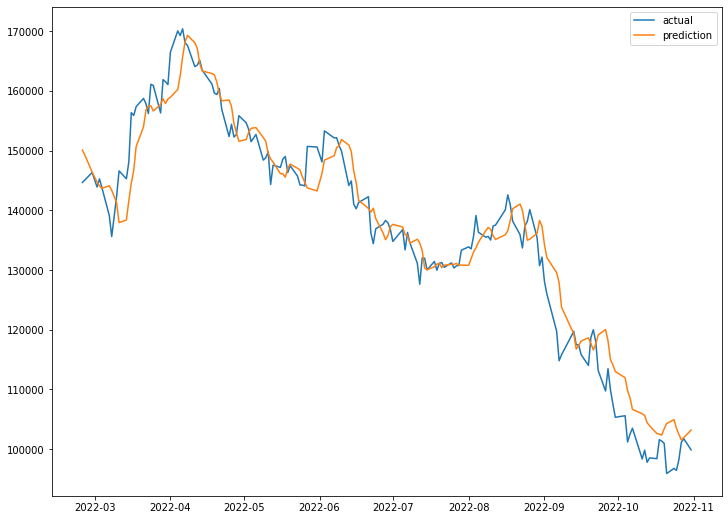

In [188]:
# 시각화

plt.figure(figsize=(12, 9))
plt.plot(y_test_graph, label='actual')
plt.plot(pred_graph, label='prediction')
plt.legend()
plt.show()

In [189]:
# 예측한 다음날(2022-10-28) 값
pred_graph[0][-1:]

Date
2022-10-31    103189.343474
Name: 0, dtype: float64

In [169]:
#16
print(' "예측 결과, %s 다음날의 가격은 %.2f(원)입니다." ' % ( str( pred_graph.index[-1] ), pred_graph.iat[-1, 0] ) )

 "예측 결과, 2022-10-31 00:00:00 다음날의 가격은 101229.37(원)입니다." 


In [190]:
#32
print(' "예측 결과, %s 다음날의 가격은 %.2f(원)입니다." ' % ( str( pred_graph.index[-1] ), pred_graph.iat[-1, 0] ) )

 "예측 결과, 2022-10-31 00:00:00 다음날의 가격은 103189.34(원)입니다." 
